In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [6]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/halong_quality.csv', index_col='date')

In [7]:
dataFrame

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,6,6,45,3,500,NaN
3/2/2019,59,55,1,6,500,NaN
3/3/2019,43,28,5,9,500,NaN
3/4/2019,27,3,4,16,500,NaN
3/5/2019,48,17,16,1,500,NaN
...,...,...,...,...,...,...
5/28/2024,64,32,48,9,500,NaN
5/29/2024,47,20,23,8,500,NaN
5/30/2024,40,6,49,9,500,NaN


In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) # Handling missing values, fill with 0 instead of removing
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)

In [10]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [11]:
# Dataset splitting
SPLIT = 0.8
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [13]:
n_forecast = 5

In [14]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='linear'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30)                3420      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model_gru.fit(X_train, y_train, epochs=20)

Epoch 1/20
48/48 [==============================] - 4s 10ms/step - loss: 0.0365 - MAE: 0.1468
Epoch 2/20
48/48 [==============================] - 1s 19ms/step - loss: 0.0219 - MAE: 0.1181
Epoch 3/20
48/48 [==============================] - 1s 16ms/step - loss: 0.0202 - MAE: 0.1125
Epoch 4/20
48/48 [==============================] - 1s 17ms/step - loss: 0.0198 - MAE: 0.1106
Epoch 5/20
48/48 [==============================] - 1s 22ms/step - loss: 0.0187 - MAE: 0.1068
Epoch 6/20
48/48 [==============================] - 1s 18ms/step - loss: 0.0187 - MAE: 0.1070
Epoch 7/20
48/48 [==============================] - 1s 16ms/step - loss: 0.0184 - MAE: 0.1068
Epoch 8/20
48/48 [==============================] - 1s 18ms/step - loss: 0.0182 - MAE: 0.1049
Epoch 9/20
48/48 [==============================] - 1s 18ms/step - loss: 0.0179 - MAE: 0.1040
Epoch 10/20
48/48 [==============================] - 1s 17ms/step - loss: 0.0179 - MAE: 0.1038
Epoch 11/20
48/48 [==============================] - 1s 18m

In [16]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


12/12 [==============================] - 1s 3ms/step


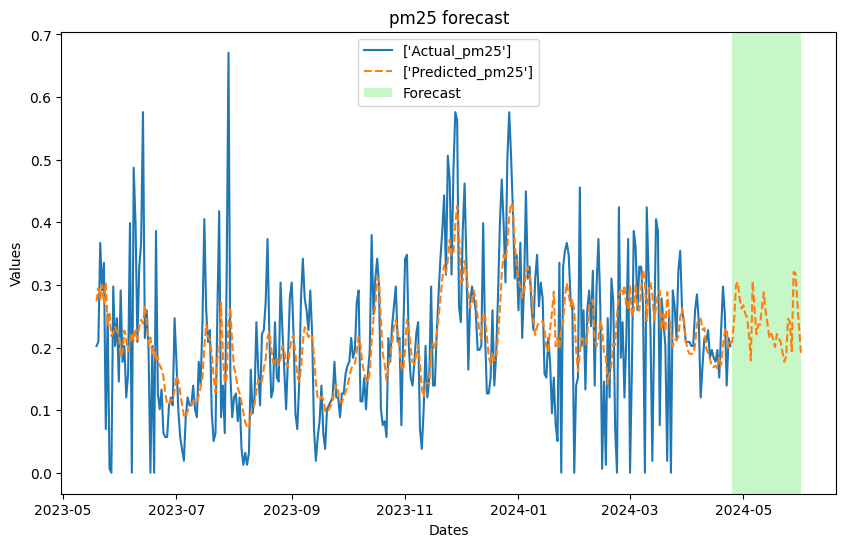

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [18]:
predicted_values

array([[0.27356476, 0.27603006, 0.27217734, 0.270884  , 0.27276894],
       [0.2944739 , 0.29601797, 0.29350805, 0.28739563, 0.2892537 ],
       [0.27874318, 0.2807669 , 0.27885926, 0.2756752 , 0.27322242],
       ...,
       [0.27169704, 0.27528146, 0.27358067, 0.2713838 , 0.2692413 ],
       [0.23067735, 0.23724735, 0.23365399, 0.23380297, 0.22762042],
       [0.18725298, 0.19254953, 0.1912215 , 0.1892108 , 0.18290284]],
      dtype=float32)

In [19]:
predicted_values_90 = predicted_values[:18]

In [20]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[48.223232 48.61275  48.00402  47.79967  48.097492]
 [51.526875 51.77084  51.37427  50.40851  50.702087]
 [49.04142  49.36117  49.05976  48.556683 48.16914 ]
 [52.415646 52.7403   52.403564 51.800884 51.67975 ]
 [47.61821  48.03892  47.783348 47.732742 47.08657 ]
 [52.9748   53.29792  53.03475  52.227264 52.177643]
 [41.957756 42.358223 42.28016  42.57732  41.075054]
 [45.119495 45.481773 45.34015  44.692837 44.08348 ]
 [39.471836 39.72646  39.763805 39.220425 38.180264]
 [40.264854 40.133526 40.43717  39.104458 38.64195 ]
 [41.78577  42.074963 42.035313 41.234024 41.04288 ]
 [40.680737 40.9447   40.92614  40.179207 40.071728]
 [39.82158  40.226276 40.06817  39.49531  39.41704 ]
 [34.186256 34.772392 34.517323 34.584145 33.93016 ]
 [35.740707 36.389103 36.054493 35.575512 35.565575]
 [40.89393  40.874462 40.82862  39.388664 40.04625 ]
 [38.52934  38.771965 38.553223 38.028175 38.012302]
 [35.713745 35.92558  35.78436  35.376995 35.123154]]


In [21]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

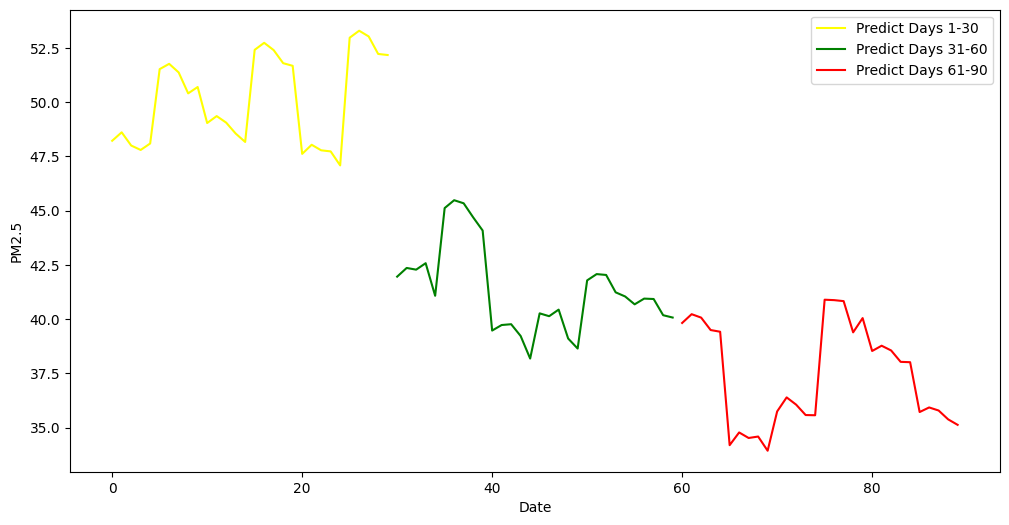

In [22]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (380, 1)
Shape of predicted_values_all: (380, 5)
RMSE: 40.14107255806657
MAE: 38.784429006080956
MAPE: 5174701875635568.0
